## USDC-USDT

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_cex = pd.read_csv("USDC_USDT_1m_from_01-05-2024.csv")
df_dex = pd.read_csv("USDT_USDC_1m_ohlc.csv")

In [25]:
# price is how much usdc 1 usdt costs
df_dex.head()

,timestamp,open,high,low,close,volume
0,2024-04-30 22:00:00,0.998740,0.998740,0.998740,0.998740,33826.042014
1,2024-04-30 22:01:00,0.998740,0.998740,0.998733,0.998733,12685.760837
2,2024-04-30 22:02:00,0.998733,0.998733,0.998733,0.998733,0.000000
3,2024-04-30 22:03:00,0.998733,0.998733,0.998733,0.998733,0.000000
4,2024-04-30 22:04:00,0.998733,0.998733,0.998733,0.998733,0.000000


In [26]:
# price is how much usdt 1 usdc costs - should be reverted
df_cex.head()

,timestamp,open,high,low,close,volume,pair
0,2024-05-01 00:00:00,1.0008,1.0009,1.0008,1.0009,97942.0,USDC/USDT
1,2024-05-01 00:01:00,1.0009,1.0009,1.0008,1.0008,102619.0,USDC/USDT
2,2024-05-01 00:02:00,1.0008,1.0009,1.0008,1.0008,299416.0,USDC/USDT
3,2024-05-01 00:03:00,1.0009,1.0009,1.0008,1.0009,102858.0,USDC/USDT
4,2024-05-01 00:04:00,1.0008,1.0009,1.0008,1.0009,904865.0,USDC/USDT


In [27]:
# reverse price for cex
df_cex["open"] = 1 / df_cex["open"]
df_cex["close"] = 1 / df_cex["close"]

df_cex["high"] = pd.concat([
    1 / df_cex["low"], 1 / df_cex["high"], df_cex["open"], df_cex["close"]
], axis=1).max(axis=1)

df_cex["low"] = pd.concat([
    df_cex["close"], df_cex["high"], df_cex["open"], 1 / df_cex["low"]
], axis=1).min(axis=1)

In [28]:
# merge cex and dex data
cex_dex = df_cex.merge(df_dex, on = "timestamp", how = "inner", suffixes=("_cex", "_dex"))

In [29]:
# take a look at what we've got
cex_dex.head()

,timestamp,open_cex,high_cex,low_cex,close_cex,volume_cex,pair,open_dex,high_dex,low_dex,close_dex,volume_dex
0,2024-05-01 00:00:00,0.999201,0.999201,0.999101,0.999101,97942.0,USDC/USDT,0.998888,0.998912,0.998888,0.998912,131640.625
1,2024-05-01 00:01:00,0.999101,0.999201,0.999101,0.999201,102619.0,USDC/USDT,0.998912,0.998923,0.998912,0.998923,110156.250
2,2024-05-01 00:02:00,0.999201,0.999201,0.999201,0.999201,299416.0,USDC/USDT,0.998923,0.998933,0.998922,0.998933,110078.125
3,2024-05-01 00:03:00,0.999101,0.999201,0.999101,0.999101,102858.0,USDC/USDT,0.998933,0.998933,0.998933,0.998933,0.000
4,2024-05-01 00:04:00,0.999201,0.999201,0.999101,0.999101,904865.0,USDC/USDT,0.998933,0.998933,0.998933,0.998933,0.000


In [30]:
# function to calculate some variables
def stat_calc(df: pd.DataFrame):
    df = df.copy()
    # absolute difference
    df["abs_diff"] = df["close_cex"] - df["close_dex"]
    # relative difference to minimal price (on cex or dex)
    df["rel_diff"] = (abs(df["abs_diff"]) / df[["close_dex", "close_cex"]].min(axis=1))
    # buy where price is lower
    df["buy"] = np.where(df["abs_diff"] > 0, "DEX", "CEX")
    # sell where price is higher
    df["sell"] = np.where(df["abs_diff"] <= 0, "DEX", "CEX")
    return df
    

In [31]:
# calculate simple variables - apply stat_calc
df_stat = stat_calc(cex_dex)

In [32]:
# fees

# uniswap fee for this pool is 0.01%
dex_pool_fee = 0.0001

# consider 2 different fees for cex: 0.1% is default for spot on binance 
cex_fee_def = 0.001
# minimal fee for binance spot: VIP9 + pay in BNB
cex_fee_min = 0.0001725
# calculate buy and sell prices with fees
df_stat["buy_price_fee_def"] = np.where(df_stat["buy"] == "CEX", df_stat["close_cex"] / (1-cex_fee_def), df_stat["close_dex"] / (1-dex_pool_fee))
df_stat["sell_price_fee_def"] = np.where(df_stat["sell"] == "CEX", df_stat["close_cex"]*(1-cex_fee_def), df_stat["close_dex"] * (1-dex_pool_fee))
# min fee
df_stat["buy_price_fee_min"] = np.where(df_stat["buy"] == "CEX", df_stat["close_cex"] / (1-cex_fee_min), df_stat["close_dex"] / (1-dex_pool_fee))
df_stat["sell_price_fee_min"] = np.where(df_stat["sell"] == "CEX", df_stat["close_cex"]*(1-cex_fee_min), df_stat["close_dex"] * (1-dex_pool_fee))


In [33]:
# calculation of spreads
df_stat["price_spread_fee_def"] = (df_stat["sell_price_fee_def"] - df_stat["buy_price_fee_def"]) / df_stat["buy_price_fee_def"]
df_stat["price_spread_fee_min"] = (df_stat["sell_price_fee_min"] - df_stat["buy_price_fee_min"]) / df_stat["buy_price_fee_min"]


In [34]:
# it's possible to consider different strategies depending on value of spread threshold: the higher it is - the less signals you get

# in the further code we will get statistics for several thresholds

# here we will make calculations with a threshold 0 with a purpose of visualization
# define threshold
spread_threshold = 0
# create signal variable: 1 if spread is larger than threshold
df_stat["signal_fee_def"] = np.where(df_stat["price_spread_fee_def"] > spread_threshold, 1, 0)
df_stat["signal_fee_min"] = np.where(df_stat["price_spread_fee_min"] > spread_threshold, 1, 0)

print(f"Total number of signals with threshold = {spread_threshold} and default CEX fee = {cex_fee_def}: {df_stat["signal_fee_def"].sum()}")
print(f"Total number of signals with threshold = {spread_threshold} and minimal CEX fee = {cex_fee_min}: {df_stat["signal_fee_min"].sum()}")

# shift signal variable to compare it with itself: if values are different - new sequence starts
df_stat["sequence_id_fee_def"] = (df_stat["signal_fee_def"] != df_stat["signal_fee_def"].shift()).cumsum()
# choose sequences with signal presence (1)
groups_with_signal_fee_def = df_stat[df_stat['signal_fee_def'] == 1].groupby("sequence_id_fee_def").size()
# average window size
average_signal_duration_fee_def = groups_with_signal_fee_def.mean()

# same for minimal fee
df_stat["sequence_id_fee_min"] = (df_stat["signal_fee_min"] != df_stat["signal_fee_min"].shift()).cumsum()
# choose sequences with signal presence (1)
groups_with_signal_fee_min = df_stat[df_stat['signal_fee_min'] == 1].groupby("sequence_id_fee_min").size()
# average window size
average_signal_duration_fee_min = groups_with_signal_fee_min.mean()

Total number of signals with threshold = 0 and default CEX fee = 0.001: 220
Total number of signals with threshold = 0 and minimal CEX fee = 0.0001725: 2396


In [35]:
# longest window for def fee
# pretty large spread
longest_window_index = groups_with_signal_fee_def.idxmax()
df_stat[df_stat["sequence_id_fee_def"] == longest_window_index]

,timestamp,open_cex,high_cex,low_cex,close_cex,volume_cex,pair,open_dex,high_dex,low_dex,...,buy_price_fee_def,sell_price_fee_def,buy_price_fee_min,sell_price_fee_min,price_spread_fee_def,price_spread_fee_min,signal_fee_def,signal_fee_min,sequence_id_fee_def,sequence_id_fee_min
256589,2024-10-26 04:29:00,0.998602,0.998702,0.998602,0.998702,38205.0,USDC/USDT,0.998669,0.998669,0.909559,...,0.967526,0.997703,0.967526,0.998529,0.031190,0.032044,1,1,84,820
256590,2024-10-26 04:30:00,0.998702,0.998702,0.998702,0.998702,165040.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997703,0.967526,0.998529,0.031190,0.032044,1,1,84,820
256591,2024-10-26 04:31:00,0.998602,0.998702,0.998602,0.998602,190558.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997603,0.967526,0.998430,0.031087,0.031941,1,1,84,820
256592,2024-10-26 04:32:00,0.998702,0.998702,0.998702,0.998702,90389.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997703,0.967526,0.998529,0.031190,0.032044,1,1,84,820
256593,2024-10-26 04:33:00,0.998602,0.998702,0.998602,0.998702,76935.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997703,0.967526,0.998529,0.031190,0.032044,1,1,84,820
256594,2024-10-26 04:34:00,0.998702,0.998702,0.998702,0.998702,831204.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997703,0.967526,0.998529,0.031190,0.032044,1,1,84,820
256595,2024-10-26 04:35:00,0.998702,0.998702,0.998602,0.998602,869480.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997603,0.967526,0.998430,0.031087,0.031941,1,1,84,820
256596,2024-10-26 04:36:00,0.998702,0.998702,0.998702,0.998702,641883.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997703,0.967526,0.998529,0.031190,0.032044,1,1,84,820
256597,2024-10-26 04:37:00,0.998702,0.998702,0.998702,0.998702,50965.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997703,0.967526,0.998529,0.031190,0.032044,1,1,84,820
256598,2024-10-26 04:38:00,0.998702,0.998702,0.998702,0.998702,24986.0,USDC/USDT,0.967429,0.967429,0.967429,...,0.967526,0.997703,0.967526,0.998529,0.031190,0.032044,1,1,84,820


In [36]:
# longest window for min fee
# very small spread 
longest_window_index = groups_with_signal_fee_min.idxmax()
df_stat[df_stat["sequence_id_fee_min"] == longest_window_index]

,timestamp,open_cex,high_cex,low_cex,close_cex,volume_cex,pair,open_dex,high_dex,low_dex,...,buy_price_fee_def,sell_price_fee_def,buy_price_fee_min,sell_price_fee_min,price_spread_fee_def,price_spread_fee_min,signal_fee_def,signal_fee_min,sequence_id_fee_def,sequence_id_fee_min
400498,2025-02-03 02:58:00,1.0002,1.000300,1.0002,1.0002,10091134.0,USDC/USDT,0.999942,0.999971,0.999874,...,0.999975,0.9992,0.999975,1.000028,-0.000775,0.000052,0,1,251,2316
400499,2025-02-03 02:59:00,1.0001,1.000200,1.0001,1.0001,4929346.0,USDC/USDT,0.999875,0.999875,0.999636,...,0.999744,0.9991,0.999744,0.999927,-0.000645,0.000183,0,1,251,2316
400500,2025-02-03 03:00:00,1.0002,1.000200,1.0001,1.0001,5007976.0,USDC/USDT,0.999644,0.999698,0.999644,...,0.999787,0.9991,0.999787,0.999927,-0.000688,0.000140,0,1,251,2316
400501,2025-02-03 03:01:00,1.0000,1.000100,1.0000,1.0000,2550517.0,USDC/USDT,0.999687,0.999687,0.999673,...,0.999777,0.9990,0.999777,0.999827,-0.000777,0.000051,0,1,251,2316
400502,2025-02-03 03:02:00,1.0000,1.000100,1.0000,1.0000,2599728.0,USDC/USDT,0.999677,0.999677,0.999640,...,0.999748,0.9990,0.999748,0.999827,-0.000748,0.000080,0,1,251,2316
400503,2025-02-03 03:03:00,1.0000,1.000200,1.0000,1.0001,2744222.0,USDC/USDT,0.999648,0.999648,0.999633,...,0.999741,0.9991,0.999741,0.999927,-0.000641,0.000187,0,1,251,2316
400504,2025-02-03 03:04:00,1.0002,1.000200,1.0000,1.0000,1888752.0,USDC/USDT,0.999641,0.999641,0.999630,...,0.999731,0.9990,0.999731,0.999827,-0.000731,0.000097,0,1,251,2316
400505,2025-02-03 03:05:00,1.0000,1.000100,1.0000,1.0001,1514033.0,USDC/USDT,0.999631,0.999684,0.999627,...,0.999781,0.9991,0.999781,0.999927,-0.000682,0.000146,0,1,251,2316
400506,2025-02-03 03:06:00,1.0000,1.000200,1.0000,1.0002,5370959.0,USDC/USDT,0.999681,0.999681,0.999681,...,0.999781,0.9992,0.999781,1.000028,-0.000581,0.000247,0,1,251,2316
400507,2025-02-03 03:07:00,1.0002,1.000200,1.0001,1.0001,2815336.0,USDC/USDT,0.999681,0.999769,0.999675,...,0.999779,0.9991,0.999779,0.999927,-0.000679,0.000148,0,1,251,2316


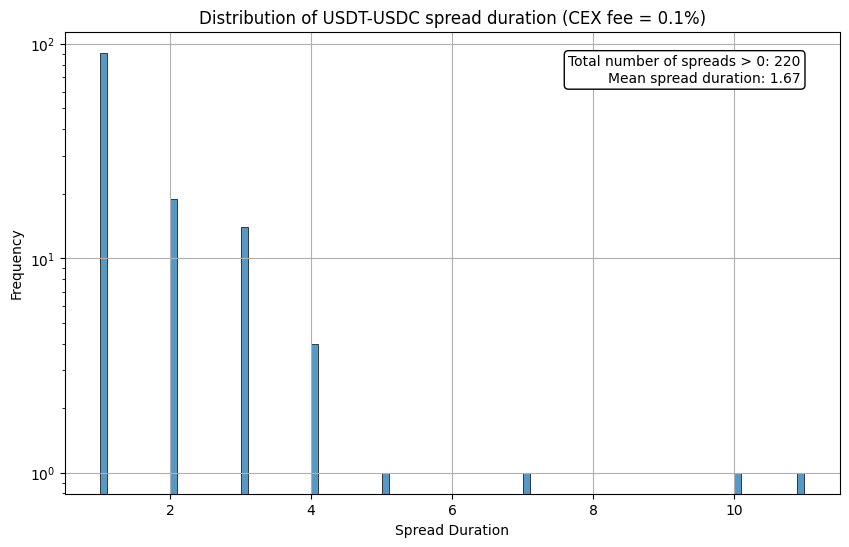

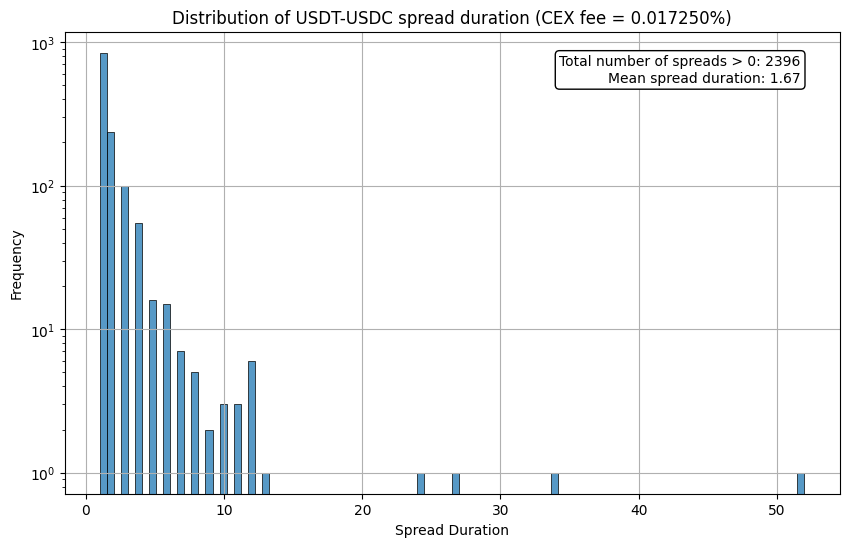

In [37]:
# plot distribution of windows' length of positive spreads

# def cex fee
filtered = df_stat[(df_stat['price_spread_fee_def'] > 0)]
count = len(filtered)
mean_val = filtered['price_spread_fee_def'].mean()

plt.figure(figsize=(10, 6))
sns.histplot(groups_with_signal_fee_def , bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of USDT-USDC spread duration (CEX fee = 0.1%)')
plt.xlabel('Spread Duration')
plt.ylabel('Frequency')
plt.grid(True)
plt.text(
    0.95, 0.95,
    f'Total number of spreads > 0: {count}\nMean spread duration: {average_signal_duration_fee_def:.2f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
)
plt.show()

# min cex fee
filtered = df_stat[(df_stat['price_spread_fee_min'] > 0)]
count = len(filtered)
mean_val = filtered['price_spread_fee_min'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(groups_with_signal_fee_min, bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of USDT-USDC spread duration (CEX fee = 0.017250%)')
plt.xlabel('Spread Duration')
plt.ylabel('Frequency')
plt.grid(True)

plt.text(
    0.95, 0.95,
    f'Total number of spreads > 0: {count}\nMean spread duration: {average_signal_duration_fee_def:.2f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
)

plt.show()

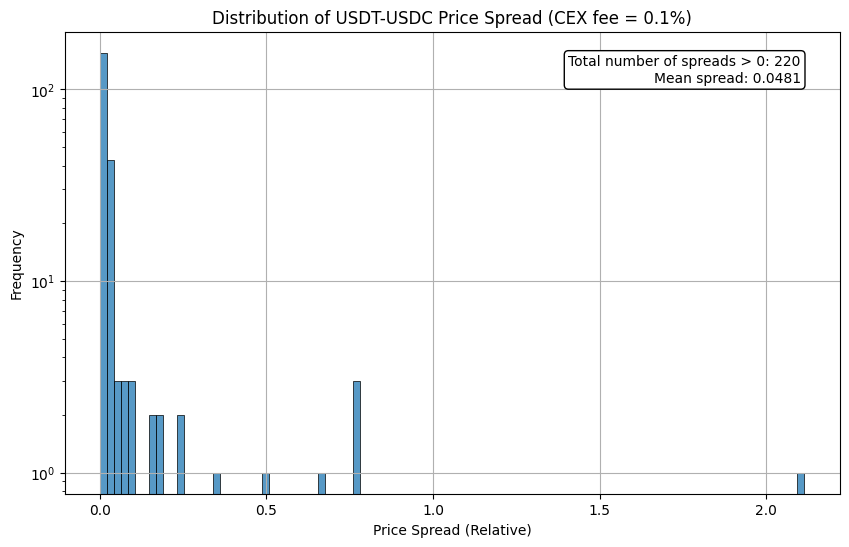

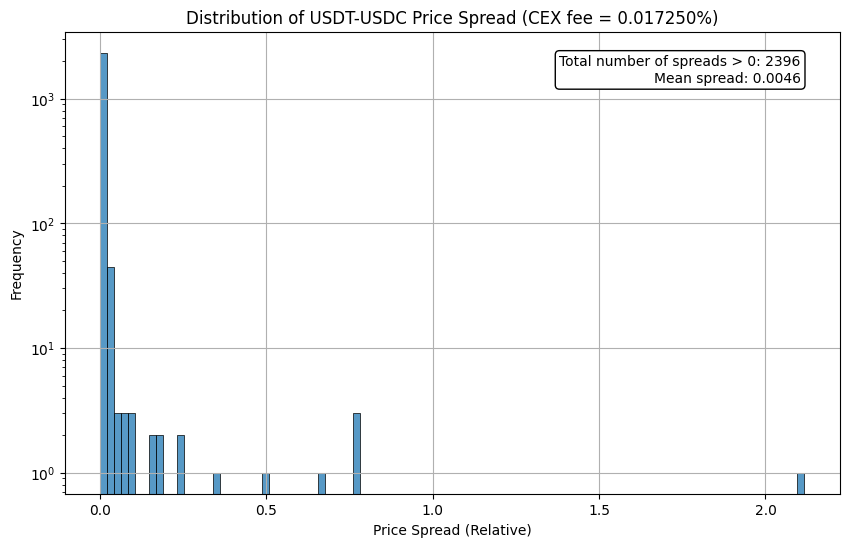

In [38]:
# plot distribution of positive spreads
# consider only spreads larger than 0

# def cex fee
filtered = df_stat[(df_stat['price_spread_fee_def'] > 0)]
count = len(filtered)
mean_val = filtered['price_spread_fee_def'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(filtered['price_spread_fee_def'] , bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of USDT-USDC Price Spread (CEX fee = 0.1%)')
plt.xlabel('Price Spread (Relative)')
plt.ylabel('Frequency')
plt.grid(True)
plt.text(
    0.95, 0.95,
    f'Total number of spreads > 0: {count}\nMean spread: {mean_val:.4f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
)
plt.show()

# min cex fee
filtered = df_stat[(df_stat['price_spread_fee_min'] > 0)]
count = len(filtered)
mean_val = filtered['price_spread_fee_min'].mean()
plt.figure(figsize=(10, 6))
sns.histplot(filtered['price_spread_fee_min'] , bins=100, kde=False)
plt.yscale('log')
plt.title('Distribution of USDT-USDC Price Spread (CEX fee = 0.017250%)')
plt.xlabel('Price Spread (Relative)')
plt.ylabel('Frequency')
plt.grid(True)

plt.text(
    0.95, 0.95,
    f'Total number of spreads > 0: {count}\nMean spread: {mean_val:.4f}',
    horizontalalignment='right',
    verticalalignment='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black")
)

plt.show()

In [39]:
# it's possible to consider different strategies depending on value of spread threshold: the higher it is - the less signals you get
# define thresholds
spread_thresholds = [0, 0.005, 0.01]

def signal(thresholds : list):
    results = {}
    # iterate over thresholds
    for spread_threshold in thresholds:
    # create signal variable: 1 if spread is larger than threshold
        signal_fee_def = np.where(df_stat["price_spread_fee_def"] > spread_threshold, 1, 0)
        signal_fee_min = np.where(df_stat["price_spread_fee_min"] > spread_threshold, 1, 0)
        results["threshold_" + str(spread_threshold)] = (signal_fee_def.sum(), signal_fee_min.sum())
    # display results
        print("---------------------------------------------------------------------------------------------------")
        print(f"Total number of signals with threshold = {spread_threshold} and default CEX fee = {cex_fee_def}: {signal_fee_def.sum()}")
        print(f"Total number of signals with threshold = {spread_threshold} and minimal CEX fee = {cex_fee_min}: {signal_fee_min.sum()}")
        print("---------------------------------------------------------------------------------------------------")
    return results
number_of_signals = signal(spread_thresholds)


---------------------------------------------------------------------------------------------------
Total number of signals with threshold = 0 and default CEX fee = 0.001: 220
Total number of signals with threshold = 0 and minimal CEX fee = 0.0001725: 2396
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Total number of signals with threshold = 0.005 and default CEX fee = 0.001: 174
Total number of signals with threshold = 0.005 and minimal CEX fee = 0.0001725: 176
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Total number of signals with threshold = 0.01 and default CEX fee = 0.001: 127
Total number of signals with threshold = 0.01 and minimal CEX fee = 0.0001725: 132
-----------------

In [40]:
# calculation of average spread time length
def avg_spread_window(thresholds):
    results = {}
    for spread_threshold in thresholds:
        # compute signals
        signal_fee_def = np.where(df_stat["price_spread_fee_def"] > spread_threshold, 1, 0)
        signal_fee_min = np.where(df_stat["price_spread_fee_min"] > spread_threshold, 1, 0)

        df_stat["signal_fee_def"] = signal_fee_def
        # shift signal variable to compare it with itself: if values are different - new sequence starts
        df_stat["sequence_id_fee_def"] = (df_stat["signal_fee_def"] != df_stat["signal_fee_def"].shift()).cumsum()
        # choose sequences with signal presence (1)
        groups_with_signal_fee_def = df_stat[df_stat['signal_fee_def'] == 1].groupby("sequence_id_fee_def").size()
        # average window size
        average_signal_duration_fee_def = groups_with_signal_fee_def.mean()

        # same for minimal fee
        df_stat["signal_fee_min"] = signal_fee_min
        df_stat["sequence_id_fee_min"] = (df_stat["signal_fee_min"] != df_stat["signal_fee_min"].shift()).cumsum()
        # choose sequences with signal presence (1)
        groups_with_signal_fee_min = df_stat[df_stat['signal_fee_min'] == 1].groupby("sequence_id_fee_min").size()
        # average window size
        average_signal_duration_fee_min = groups_with_signal_fee_min.mean()

        print("---------------------------------------------------------------------------------------------------")
        print(f"Average duration of a signal (with defaul CEX fee = {cex_fee_def}) is: {average_signal_duration_fee_def:.2f}.")
        print(f"Average duration of a signal (with minimal CEX fee = {cex_fee_min}) is: {average_signal_duration_fee_min:.2f}.")
        print("---------------------------------------------------------------------------------------------------")

        results["threshold_" + str(spread_threshold)] = (average_signal_duration_fee_def, average_signal_duration_fee_min)

    # drop auxilary columns no to mess data
    df_stat.drop(columns = ["signal_fee_def", "sequence_id_fee_def", "signal_fee_min", "sequence_id_fee_min"], axis = 1)
    return results
avg_spread_windows = avg_spread_window(spread_thresholds)

---------------------------------------------------------------------------------------------------
Average duration of a signal (with defaul CEX fee = 0.001) is: 1.67.
Average duration of a signal (with minimal CEX fee = 0.0001725) is: 1.85.
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Average duration of a signal (with defaul CEX fee = 0.001) is: 1.67.
Average duration of a signal (with minimal CEX fee = 0.0001725) is: 1.68.
---------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------
Average duration of a signal (with defaul CEX fee = 0.001) is: 1.72.
Average duration of a signal (with minimal CEX fee = 0.0001725) is: 1.67.
-----------------------------------------------------------------------

In [41]:
# is there a mistake in data
# # max spread
max_spread = df_stat["price_spread_fee_def"].max()
print(f"Max spread is: {max_spread:.4f}.")

Max spread is: 2.1142.


In [42]:
df_stat["price_spread_fee_def"].argmax()

163734

In [43]:
# suspicious transaction with hash 0xa8fc6eb5955a56dce3a6363d684428e2775df5eff35baf3eef83e26320bbf8cc
df_dex.iloc[163850:163858]


,timestamp,open,high,low,close,volume
163850,2024-08-22 16:50:00,1.000328,1.000328,1.000328,1.000328,3.471176e+01
163851,2024-08-22 16:51:00,1.000328,1.000328,1.000328,1.000328,1.944651e+02
163852,2024-08-22 16:52:00,1.000328,1.000328,1.000328,1.000328,0.000000e+00
163853,2024-08-22 16:53:00,1.000328,1.000328,1.000328,1.000328,5.866691e+03
163854,2024-08-22 16:54:00,1.000328,1.000328,0.320883,0.320883,2.553688e+07
163855,2024-08-22 16:55:00,0.320883,1.000132,0.320883,1.000127,7.450419e+05
163856,2024-08-22 16:56:00,1.000127,1.000133,1.000127,1.000133,2.826735e+04
163857,2024-08-22 16:57:00,1.000133,1.000133,1.000133,1.000133,0.000000e+00


In [44]:
# suspicious
df_stat[df_stat["price_spread_fee_def"] > 0.4]

,timestamp,open_cex,high_cex,low_cex,close_cex,volume_cex,pair,open_dex,high_dex,low_dex,...,buy_price_fee_def,sell_price_fee_def,buy_price_fee_min,sell_price_fee_min,price_spread_fee_def,price_spread_fee_min,signal_fee_def,signal_fee_min,sequence_id_fee_def,sequence_id_fee_min
39471,2024-05-28 09:51:00,0.998901,0.999001,0.998901,0.999001,53019.0,USDC/USDT,0.999058,0.999058,0.662868,...,0.662934,0.998002,0.662934,0.998829,0.505432,0.506679,1,1,2,2
163734,2024-08-22 16:54:00,1.000400,1.000400,1.000400,1.000400,42125.0,USDC/USDT,1.000328,1.000328,0.320883,...,0.320915,0.999400,0.320915,1.000228,2.114221,2.116801,1,1,32,34
354493,2025-01-02 04:13:00,0.998104,0.998203,0.998104,0.998104,86223.0,USDC/USDT,0.998176,0.998176,0.560497,...,0.560553,0.997105,0.560553,0.997931,0.778788,0.780261,1,1,122,132
354494,2025-01-02 04:14:00,0.998203,0.998203,0.998203,0.998203,613256.0,USDC/USDT,0.560497,0.560497,0.560497,...,0.560553,0.997205,0.560553,0.998031,0.778965,0.780439,1,1,122,132
354495,2025-01-02 04:15:00,0.998104,0.998203,0.998104,0.998203,33302.0,USDC/USDT,0.560497,0.560497,0.560497,...,0.560553,0.997205,0.560553,0.998031,0.778965,0.780439,1,1,122,132
434331,2025-02-26 14:51:00,0.998901,0.999001,0.998901,0.998901,1247961.0,USDC/USDT,0.999028,0.999028,0.600391,...,0.600982,0.997902,0.600982,0.998729,0.660452,0.661827,1,1,142,152
